# 雰囲気推定 AI

データセットにある物件画像から、物件の内装の雰囲気を推定する。

推定項目は以下の通り。

- 向かいの部屋からのぞけそうか（窓にほかの建物が映っているか）
- 窓から緑が見えるか
- 壁に模様があるか

これらの項目を選択した理由は、基準が明確であり評価をしやすいのに加えて、実際に一定数のユーザーにとって検討材料になる見込みが高いためである。実運用時には、より多くの項目について、基準が難しいものについても AI で推定してもよいかもしれない。

推定には[BLIP](https://huggingface.co/docs/transformers/model_doc/blip)を使用する。**BLIP**は画像とテキストを扱うマルチモーダルな深層学習モデルであり、ここでは画像に対してテキストで質問を行える**Visual Question Answering**用の学習済みモデルをロードする。

実行には PyTorch が動作する環境が必要です。https://pytorch.org/get-started/locally/ を参考にして、Torch をインストールしてください。

また、処理の時間短縮のために GPU を使用するには、CUDA Toolkit もインストールしてください。


In [ ]:
%pip install -U torch torchvision torchaudio
# if windows:
# %pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install transformers Pillow requests torch

In [30]:
import json

# scraping.ipynbで生成したjsonファイルを読み込む
with open("samples.json", encoding="utf-8") as f:
    samples = json.load(f)

samples[0]  # 1つ目の物件情報を表示

{'title': 'ファブール千川',
 'address': '東京都板橋区大谷口上町',
 'rent': 4.7,
 'layout': 'ワンルーム',
 'area': 14.08,
 'age': 50,
 'access': '東京メトロ有楽町線/千川駅 歩15分',
 'distance': 15,
 'image_urls': ['https://img01.suumo.com/front/gazo/fr/bukken/619/100367847619/100367847619_gw.jpg',
  'https://img01.suumo.com/front/gazo/fr/bukken/619/100367847619/100367847619_11w.jpg',
  'https://img01.suumo.com/front/gazo/fr/bukken/619/100367847619/100367847619_rw.jpg',
  'https://img01.suumo.com/front/gazo/fr/bukken/619/100367847619/100367847619_1w.jpg',
  'https://img01.suumo.com/front/gazo/fr/bukken/619/100367847619/100367847619_2w.jpg']}

In [ ]:
from PIL import Image
import requests
from transformers import (
    BlipProcessor,
    BlipForImageTextRetrieval,
    BlipForQuestionAnswering,
)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# 画像とテキストのコサイン類似度を計算するモデル
# model_itm = BlipForImageTextRetrieval.from_pretrained(
#     "Salesforce/blip-itm-base-coco"
# ).to(device)
# processor_itm = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")

# 画像に対して対話形式で質問をするモデル
model_vqa = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(
    device
)
processor_vqa = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

まず、物件画像の中から**内装の画像**をフィルタする。物件画像には建物の外装や間取り図が含まれている場合があり、内装に関する質問を投げる前にこれらを取り除く必要がある。


In [16]:
def vqa_question(images, question) -> bool:
    """画像のリストに対してYes/Noタイプの質問をする"""

    inputs = processor_vqa(images=images, text=question, return_tensors="pt").to(device)
    outputs = model_vqa.generate(**inputs)
    answers = [
        processor_vqa.decode(output, skip_special_tokens=True) == "yes"
        for output in outputs
    ]
    return answers

c:\Users\qrtz\scoop\apps\python311\current\Lib\site-packages\transformers\generation\utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


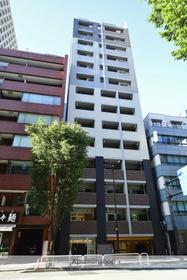

'Interia: False'

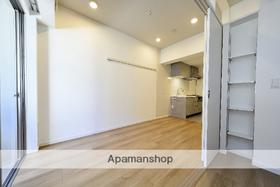

'Interia: True'

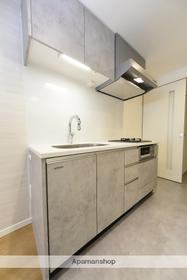

'Interia: True'

In [18]:
# 一部の画像を用いて、内装の画像が取り出せるかをテストする

images = [
    Image.open(requests.get(url, stream=True).raw).convert("RGB")
    for url in samples[3]["image_urls"][:3]
]

answers = vqa_question(images, "Is the image a picture of room interia?")  # 画像が内装の写真かどうか？

for image, answer in zip(images, answers):
    display(image, f"Interia: {answer}")

物件画像から内装のみを取り出せたので、次は内装画像から部屋の雰囲気が推定できるかをテストする。

In [14]:
def estimate_atmosphere(images):
    """物件画像から部屋の雰囲気を推定"""

    is_peekable = vqa_question(
        images, "Can other buidlings be seen through windows?"
    )  # ほかの建物が窓から見えるか
    is_green_visible = vqa_question(
        images,
        "Are there views of greenery visible from the room?",  # 部屋から緑が見えるか？
    )
    is_wall_patterned = vqa_question(
        images, "Is the wall patterned?"
    )  # 壁に模様があるか

    return {
        "atmos_peekable": is_peekable,
        "atmos_green_visible": is_green_visible,
        "atmos_wall_patterned": is_wall_patterned,
    }

c:\Users\qrtz\scoop\apps\python311\current\Lib\site-packages\transformers\generation\utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


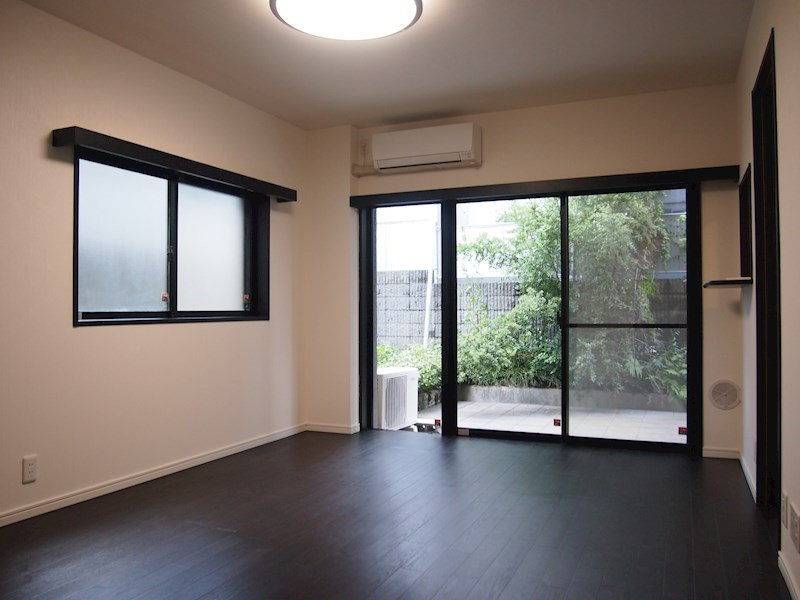

{'atmos_peekable': False,
 'atmos_green_visible': True,
 'atmos_wall_patterned': False}

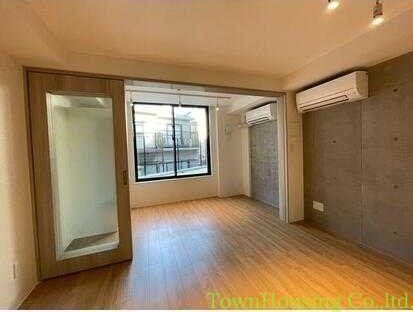

{'atmos_peekable': True,
 'atmos_green_visible': False,
 'atmos_wall_patterned': False}

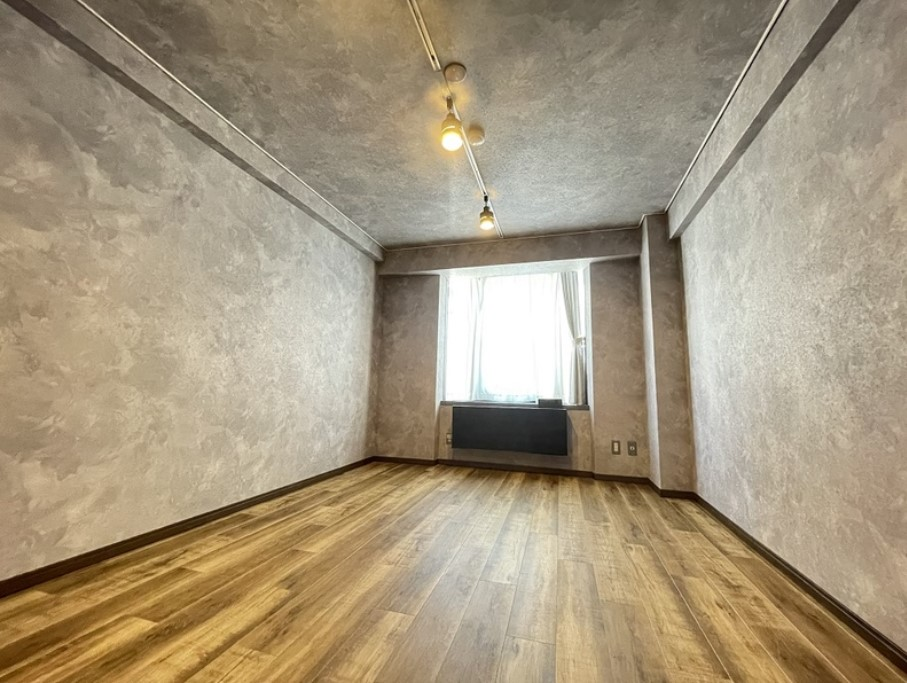

{'atmos_peekable': False,
 'atmos_green_visible': False,
 'atmos_wall_patterned': True}

In [15]:
# 複数のリビングの画像を使用して推定をテストする

living_urls = [
    "https://img01.suumo.com/front/gazo/fr/bukken/869/100366038869/100366038869_1o.jpg",
    "https://img01.suumo.com/front/gazo/fr/bukken/152/100361252152/100361252152_ro.jpg",
    "https://img01.suumo.com/front/gazo/fr/bukken/262/100367095262/100367095262_ro.jpg",
]
living_images = [
    Image.open(requests.get(url, stream=True).raw).convert("RGB") for url in living_urls
]

atmosphere = estimate_atmosphere(living_images)

for i, image in enumerate(living_images):
    display(image, {k: v[i] for k, v in atmosphere.items()})

## 実データを用いた推定

では、実データを用いて推定を行う。

c:\Users\qrtz\scoop\apps\python311\current\Lib\site-packages\transformers\generation\utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'atmos_peekable': False,
 'atmos_green_visible': True,
 'atmos_wall_patterned': False}

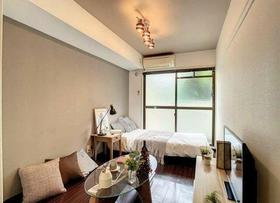

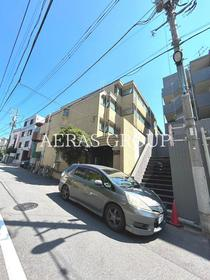

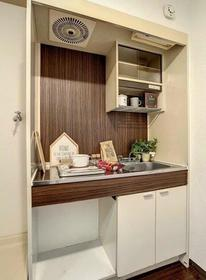

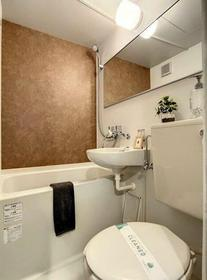

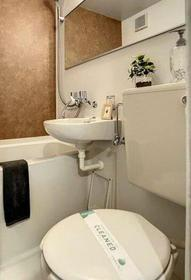

In [40]:
def real_estimate(image_urls):
    """実際の複数の物件画像から内装の雰囲気を推定する"""

    images = [
        Image.open(requests.get(url, stream=True).raw).convert("RGB")
        for url in image_urls
    ]

    if len(images) == 0:
        return {}

    answers = vqa_question(images, "Is the image a picture of room interia?")  # 画像が内装の写真かどうか？
    images = [image for image, answer in zip(images, answers) if answer] # 内装の画像のみを選択

    if len(images) == 0:
        return {}

    results = estimate_atmosphere(images) # 各画像の推定結果

    atmosphere = {} # 1つの物件全体の雰囲気の推定結果
    atmosphere["atmos_peekable"] = any(results["atmos_peekable"]) # cf. 1つでも窓に建物が映っている画像があれば、その物件は外から覗かれ得る
    atmosphere["atmos_green_visible"] = any(results["atmos_green_visible"])
    atmosphere["atmos_wall_patterned"] = any(results["atmos_wall_patterned"])
    
    return atmosphere


# 推定のテスト
display(real_estimate(samples[7]["image_urls"]))

images = [
    Image.open(requests.get(url, stream=True).raw).convert("RGB")
    for url in samples[7]["image_urls"]
]
for image in images:
    display(image)

In [42]:
atmos_list = []

for i, sample in enumerate(samples):
    print(".", end="")
    atmos_list.append(real_estimate(sample["image_urls"]))


.

c:\Users\qrtz\scoop\apps\python311\current\Lib\site-packages\transformers\generation\utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


...................................................................................................

In [44]:
# 結果をjsonファイルにエクスポート

samples_with_atmosphere = [
    {**sample, **atmos} for sample, atmos in zip(samples, atmos_list)
]

with open("samples_with_atmosphere.json", "w", encoding="utf-8") as f:
    json.dump(samples_with_atmosphere, f, indent=2, ensure_ascii=False)